In [1]:
# --- Cell 1: Imports ---
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, 
                                     GlobalAveragePooling2D, Dense, Dropout)
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [2]:
# --- Cell 2: Paths & Parameters ---
# Customize these paths
base_dir = r"D:\School\Project\Machine_Learning\Datasets"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")

# Target image resolution (camera resolution)
img_height, img_width = 120, 160
batch_size = 16
validation_split = 0.1

# Detect classes
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)
print(f"Classes: {class_names}\nTotal classes: {num_classes}")


Classes: ['Grass_Paths', 'Gravel_Stony', 'Murram', 'Pavements', 'Stairs', 'Tarmac', 'Tiles']
Total classes: 7


In [3]:
# --- Cell 3: Create Validation Set (if not exists) ---
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for cls in class_names:
        src = os.path.join(train_dir, cls)
        dst = os.path.join(val_dir, cls)
        os.makedirs(dst, exist_ok=True)

        imgs = [f for f in os.listdir(src) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        np.random.seed(42)
        val_imgs = np.random.choice(imgs, int(len(imgs) * validation_split), replace=False)
        for img in val_imgs:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))  # Copy instead of move
    print("Validation set created.")
else:
    print("Validation set already exists.")


Validation set created.


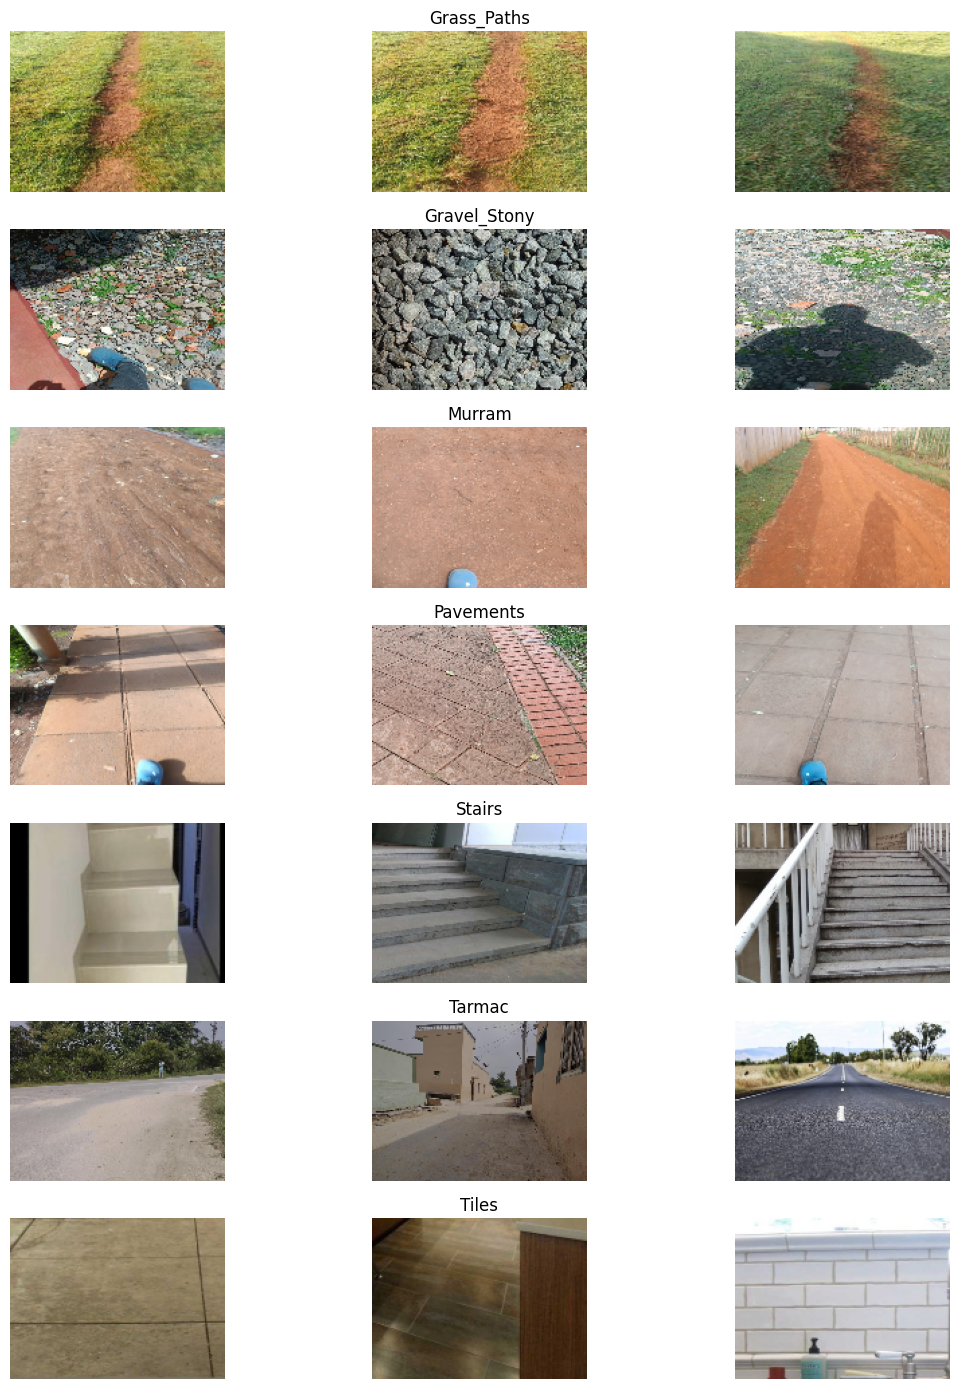

In [4]:
# -- showing randomimages

fig, axes = plt.subplots(len(class_names), 3, figsize=(12, len(class_names)*2))
for i, cls in enumerate(class_names):
    cls_path = os.path.join(val_dir, cls)
    imgs = random.sample(os.listdir(cls_path), min(3, len(os.listdir(cls_path))))
    for j, img_name in enumerate(imgs):
        img = cv2.imread(os.path.join(cls_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_width, img_height))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 1:
            axes[i, j].set_title(cls)
plt.tight_layout()
plt.show()


In [5]:
# --- Cell 5: Heavy Augmentation Data Generators ---

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented image data
train_data = train_gen.flow_from_directory(
    train_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical'
)

val_data = val_gen.flow_from_directory(
    val_dir, target_size=(img_height, img_width),
    batch_size=batch_size, class_mode='categorical'
)


Found 12582 images belonging to 7 classes.
Found 1256 images belonging to 7 classes.


In [6]:
# --- Cell 6: Compute Class Weights ---
labels = train_data.classes
weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(2.524478330658106), 1: np.float64(2.9466042154566745), 2: np.float64(1.7183829554766457), 3: np.float64(0.8111139762764311), 4: np.float64(0.42898056597340606), 5: np.float64(0.5420472169567465), 6: np.float64(3.653310104529617)}


In [7]:
# --- Cell 7: Model Definition Slimmed Model Definition (Tiny Depthwise CNN) ---
def dw_sep_block(x, filters, stride=1):
    x = DepthwiseConv2D(3, strides=stride, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, 1, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

inputs = Input(shape=(img_height, img_width, 3))

x = Conv2D(8, 3, strides=2, padding="same", use_bias=False)(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

x = dw_sep_block(x, 16)
x = dw_sep_block(x, 32, stride=2)
x = dw_sep_block(x, 32)
x = dw_sep_block(x, 64, stride=2)
x = dw_sep_block(x, 64)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 120, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 60, 80, 8)           │             216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 60, 80, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 60, 80, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d (DepthwiseConv2D)   │ (None, 60, 80, 8)           │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 60, 80, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 60, 80, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 80, 16)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 80, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 60, 80, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 30, 40, 16)          │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 40, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 30, 40, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 30, 40, 32)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 30, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 30, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_2 (DepthwiseConv2D) │ (None, 30, 40, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 40, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,479 (60.46 KB)

 Trainable params: 14,743 (57.59 KB)

 Non-trainable params: 736 (2.88 KB)

In [8]:
# --- Cell 8: Callbacks ---
callbacks = [
    EarlyStopping(patience=6, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(patience=3, monitor='val_loss', factor=0.5, min_lr=1e-5),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy")
]


In [9]:
# --- Cell 9: Train Model ---
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

C:\Users\manas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2938 - loss: 1.7619

787/787 ━━━━━━━━━━━━━━━━━━━━ 998s 1s/step - accuracy: 0.2939 - loss: 1.7617 - val_accuracy: 0.4968 - val_loss: 1.4332 - learning_rate: 1.0000e-04
Epoch 2/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.4584 - loss: 1.2787

787/787 ━━━━━━━━━━━━━━━━━━━━ 457s 581ms/step - accuracy: 0.4584 - loss: 1.2786 - val_accuracy: 0.5446 - val_loss: 1.2527 - learning_rate: 1.0000e-04
Epoch 3/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5254 - loss: 1.0732

787/787 ━━━━━━━━━━━━━━━━━━━━ 468s 595ms/step - accuracy: 0.5254 - loss: 1.0731 - val_accuracy: 0.5645 - val_loss: 1.2432 - learning_rate: 1.0000e-04
Epoch 4/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.5763 - loss: 0.9734

787/787 ━━━━━━━━━━━━━━━━━━━━ 522s 664ms/step - accuracy: 0.5763 - loss: 0.9734 - val_accuracy: 0.5732 - val_loss: 1.2062 - learning_rate: 1.0000e-04
Epoch 5/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 470s 598ms/step - accuracy: 0.5604 - loss: 0.9844 - val_accuracy: 0.5629 - val_loss: 1.2159 - learning_rate: 1.0000e-04
Epoch 6/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.5988 - loss: 0.9126

787/787 ━━━━━━━━━━━━━━━━━━━━ 353s 448ms/step - accuracy: 0.5988 - loss: 0.9126 - val_accuracy: 0.6210 - val_loss: 1.0415 - learning_rate: 1.0000e-04
Epoch 7/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 368s 468ms/step - accuracy: 0.6144 - loss: 0.8681 - val_accuracy: 0.6139 - val_loss: 1.0540 - learning_rate: 1.0000e-04
Epoch 8/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.6163 - loss: 0.8581

787/787 ━━━━━━━━━━━━━━━━━━━━ 391s 497ms/step - accuracy: 0.6163 - loss: 0.8581 - val_accuracy: 0.6258 - val_loss: 1.0099 - learning_rate: 1.0000e-04
Epoch 9/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 338s 430ms/step - accuracy: 0.6413 - loss: 0.8280 - val_accuracy: 0.6099 - val_loss: 1.0060 - learning_rate: 1.0000e-04
Epoch 10/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6588 - loss: 0.7951

787/787 ━━━━━━━━━━━━━━━━━━━━ 301s 383ms/step - accuracy: 0.6588 - loss: 0.7951 - val_accuracy: 0.6393 - val_loss: 0.9812 - learning_rate: 1.0000e-04
Epoch 11/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6544 - loss: 0.7629

787/787 ━━━━━━━━━━━━━━━━━━━━ 274s 347ms/step - accuracy: 0.6544 - loss: 0.7629 - val_accuracy: 0.6951 - val_loss: 0.8393 - learning_rate: 1.0000e-04
Epoch 12/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6667 - loss: 0.7671

787/787 ━━━━━━━━━━━━━━━━━━━━ 180s 229ms/step - accuracy: 0.6667 - loss: 0.7671 - val_accuracy: 0.6967 - val_loss: 0.7896 - learning_rate: 1.0000e-04
Epoch 13/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 193s 246ms/step - accuracy: 0.6699 - loss: 0.7443 - val_accuracy: 0.6481 - val_loss: 0.9347 - learning_rate: 1.0000e-04
Epoch 14/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6866 - loss: 0.7153

787/787 ━━━━━━━━━━━━━━━━━━━━ 185s 235ms/step - accuracy: 0.6866 - loss: 0.7153 - val_accuracy: 0.7014 - val_loss: 0.8011 - learning_rate: 1.0000e-04
Epoch 15/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 180s 228ms/step - accuracy: 0.6984 - loss: 0.6981 - val_accuracy: 0.6903 - val_loss: 0.8379 - learning_rate: 1.0000e-04
Epoch 16/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6995 - loss: 0.6941

787/787 ━━━━━━━━━━━━━━━━━━━━ 187s 238ms/step - accuracy: 0.6995 - loss: 0.6941 - val_accuracy: 0.7134 - val_loss: 0.7803 - learning_rate: 5.0000e-05
Epoch 17/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6932 - loss: 0.7168

787/787 ━━━━━━━━━━━━━━━━━━━━ 182s 231ms/step - accuracy: 0.6932 - loss: 0.7168 - val_accuracy: 0.7245 - val_loss: 0.7627 - learning_rate: 5.0000e-05
Epoch 18/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 189s 240ms/step - accuracy: 0.7066 - loss: 0.7002 - val_accuracy: 0.6887 - val_loss: 0.8601 - learning_rate: 5.0000e-05
Epoch 19/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7134 - loss: 0.6594

787/787 ━━━━━━━━━━━━━━━━━━━━ 193s 245ms/step - accuracy: 0.7134 - loss: 0.6594 - val_accuracy: 0.7285 - val_loss: 0.7682 - learning_rate: 5.0000e-05
Epoch 20/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 192s 244ms/step - accuracy: 0.7083 - loss: 0.6728 - val_accuracy: 0.7277 - val_loss: 0.7447 - learning_rate: 5.0000e-05
Epoch 21/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7047 - loss: 0.6668

787/787 ━━━━━━━━━━━━━━━━━━━━ 196s 249ms/step - accuracy: 0.7047 - loss: 0.6667 - val_accuracy: 0.7412 - val_loss: 0.7330 - learning_rate: 5.0000e-05
Epoch 22/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 193s 245ms/step - accuracy: 0.7164 - loss: 0.6607 - val_accuracy: 0.7412 - val_loss: 0.7340 - learning_rate: 5.0000e-05
Epoch 23/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7144 - loss: 0.6723

787/787 ━━━━━━━━━━━━━━━━━━━━ 171s 217ms/step - accuracy: 0.7144 - loss: 0.6723 - val_accuracy: 0.7420 - val_loss: 0.7081 - learning_rate: 5.0000e-05
Epoch 24/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.7225 - loss: 0.6456

787/787 ━━━━━━━━━━━━━━━━━━━━ 170s 217ms/step - accuracy: 0.7225 - loss: 0.6456 - val_accuracy: 0.7524 - val_loss: 0.6996 - learning_rate: 5.0000e-05
Epoch 25/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 170s 216ms/step - accuracy: 0.7175 - loss: 0.6631 - val_accuracy: 0.7404 - val_loss: 0.6785 - learning_rate: 5.0000e-05
Epoch 26/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7256 - loss: 0.6444

787/787 ━━━━━━━━━━━━━━━━━━━━ 171s 217ms/step - accuracy: 0.7256 - loss: 0.6444 - val_accuracy: 0.7699 - val_loss: 0.6680 - learning_rate: 5.0000e-05
Epoch 27/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 169s 215ms/step - accuracy: 0.7241 - loss: 0.6524 - val_accuracy: 0.7604 - val_loss: 0.7057 - learning_rate: 5.0000e-05
Epoch 28/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 172s 218ms/step - accuracy: 0.7301 - loss: 0.6230 - val_accuracy: 0.7341 - val_loss: 0.7294 - learning_rate: 5.0000e-05
Epoch 29/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7295 - loss: 0.6031

787/787 ━━━━━━━━━━━━━━━━━━━━ 171s 217ms/step - accuracy: 0.7295 - loss: 0.6032 - val_accuracy: 0.7747 - val_loss: 0.6561 - learning_rate: 5.0000e-05
Epoch 30/30
787/787 ━━━━━━━━━━━━━━━━━━━━ 168s 214ms/step - accuracy: 0.7343 - loss: 0.6354 - val_accuracy: 0.7540 - val_loss: 0.6789 - learning_rate: 5.0000e-05


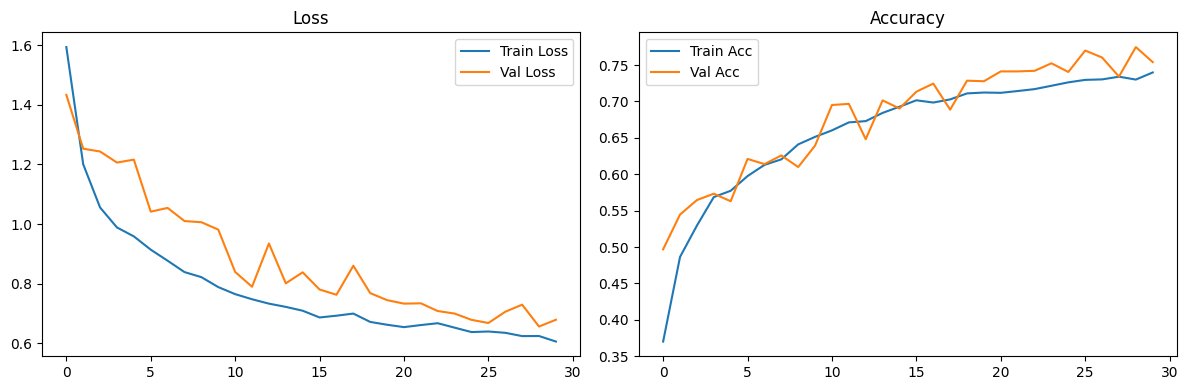

In [10]:
# --- Cell 10 : Plot Accuracy and Loss ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# --- Cell 11: Save Models ---

# Define the path to save the models
model_dir = r"D:\School\Project\Machine_Learning\Datasets\Models"
os.makedirs(model_dir, exist_ok=True)  # Ensure the directory exists

# Full paths for model files
h5_path = os.path.join(model_dir, "first.h5")
keras_path = os.path.join(model_dir, "first.keras")
tflite_path = os.path.join(model_dir, "first.tflite")

# Save the model in .h5 and .keras formats
model.save(h5_path)
model.save(keras_path)
print(f"Saved H5 model to: {h5_path}")
print(f"Saved Keras model to: {keras_path}")

# Convert to .tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite model
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print(f"Saved TFLite model to: {tflite_path}")


Saved H5 model to: D:\School\Project\Machine_Learning\Datasets\Models\first.h5
Saved Keras model to: D:\School\Project\Machine_Learning\Datasets\Models\first.keras
INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmpmyrdfmnd\assets


INFO:tensorflow:Assets written to: C:\Users\manas\AppData\Local\Temp\tmpmyrdfmnd\assets


Saved artifact at 'C:\Users\manas\AppData\Local\Temp\tmpmyrdfmnd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 120, 160, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2491054241952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054531232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054522960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054528064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054530352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054534400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054532112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054534752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054535984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2491054536864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  24910